# Notebook to plot results from deblurring

## Blurrier patches

[INFO] Image+CLIP: found 192 metrics files
[WARN] SSIM missing in /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds/amyloid_plaque_patches/cvfold0_trlim10_fttr8_ftval2_tst2_amyloid_plaque_patches_seed100/preds/metrics_test.csv
[WARN] SSIM missing in /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds/amyloid_plaque_patches/cvfold0_trlim11_fttr9_ftval2_tst2_amyloid_plaque_patches_seed100/preds/metrics_test.csv
[WARN] SSIM missing in /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds/amyloid_plaque_patches/cvfold0_trlim12_fttr10_ftval2_tst2_amyloid_plaque_patches_seed100/preds/metrics_test.csv
[WARN] SSIM missing in /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds/amyloid_plaque_patches/cvfold0_trlim13_fttr10_ftval3_tst2_amyloid_plaque_patches_seed100/preds/metrics_test.csv
[WARN] SSIM missing in /midtier/paetzollab/scratch/ads4015/temp_selma_deblur_pr

,series,subtype,train_size,metric_name,metric,csv_path
0,Image+CLIP,amyloid_plaque_patches,10,psnr,18.6191,/midtier/paetzollab/scratch/ads4015/temp_selma...
1,Image+CLIP,amyloid_plaque_patches,10,psnr,28.0971,/midtier/paetzollab/scratch/ads4015/temp_selma...
2,Image+CLIP,amyloid_plaque_patches,11,psnr,27.9858,/midtier/paetzollab/scratch/ads4015/temp_selma...
3,Image+CLIP,amyloid_plaque_patches,11,psnr,19.1165,/midtier/paetzollab/scratch/ads4015/temp_selma...
4,Image+CLIP,amyloid_plaque_patches,12,psnr,18.6397,/midtier/paetzollab/scratch/ads4015/temp_selma...


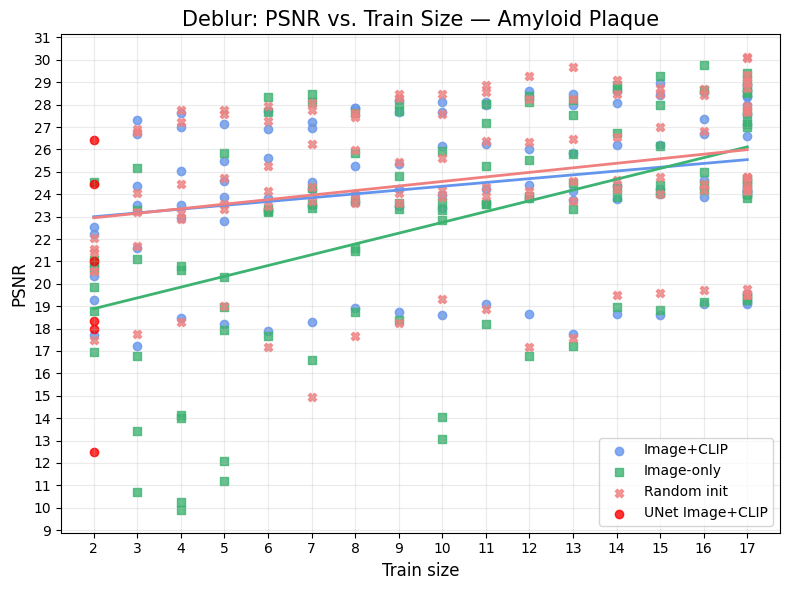

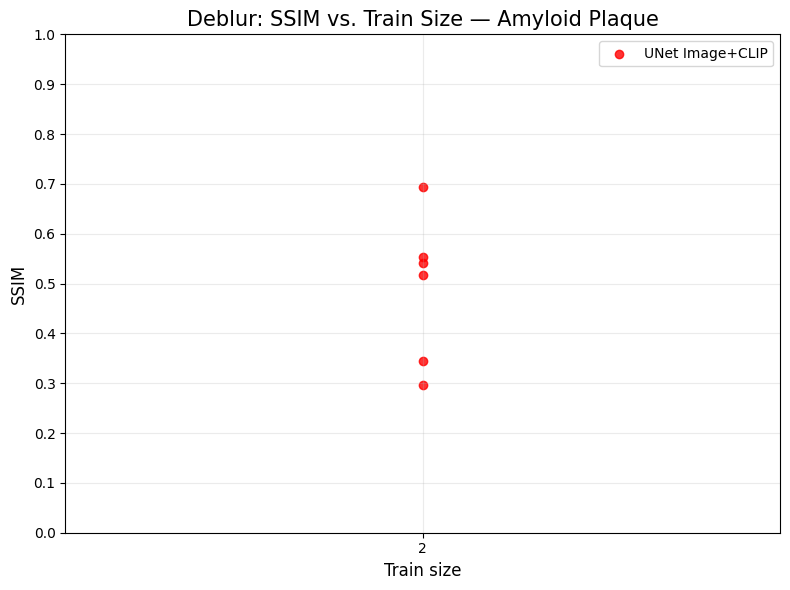

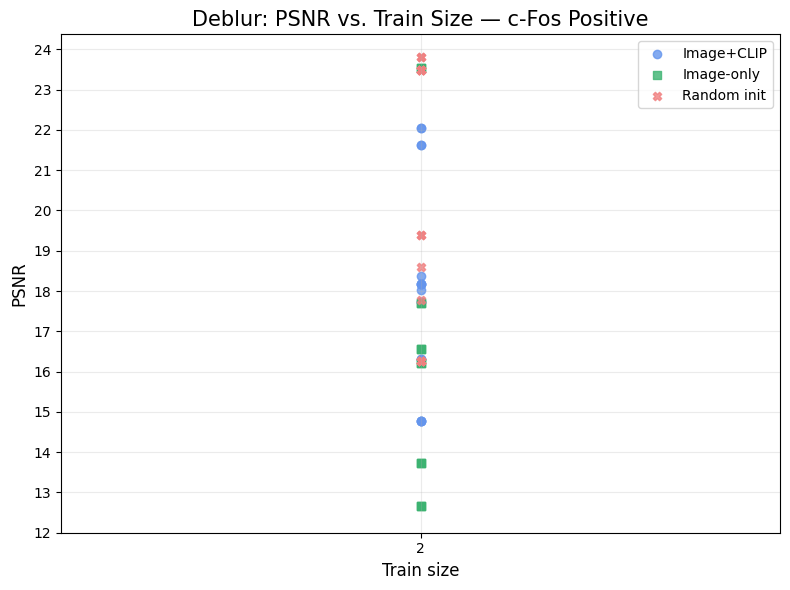

[WARN] No ssim data for subtype=c_fos_positive_patches


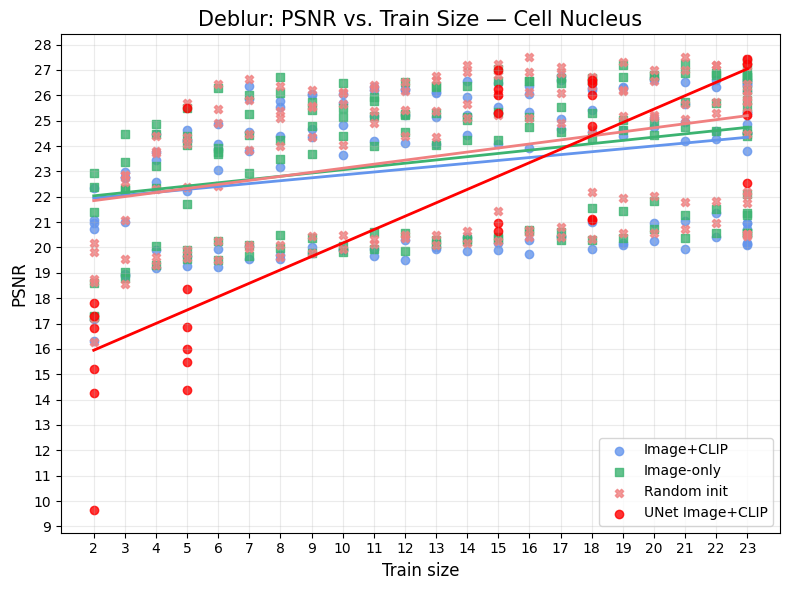

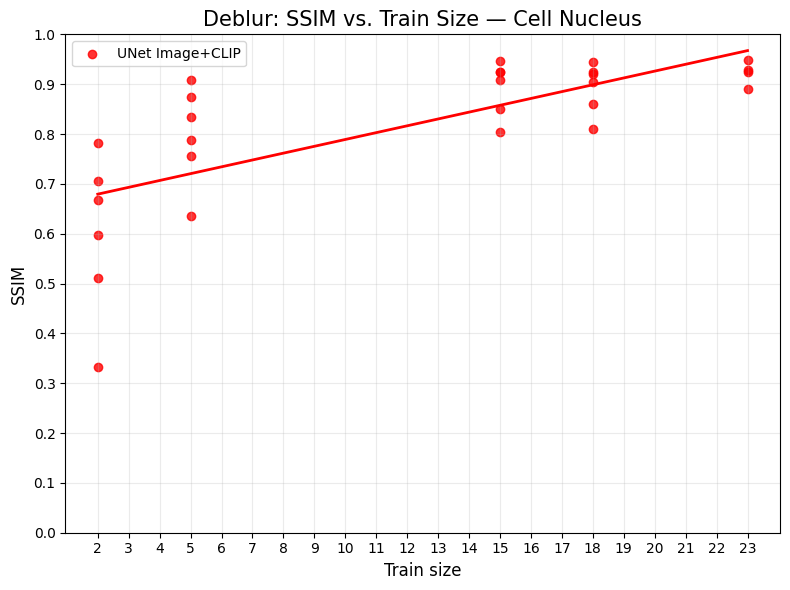

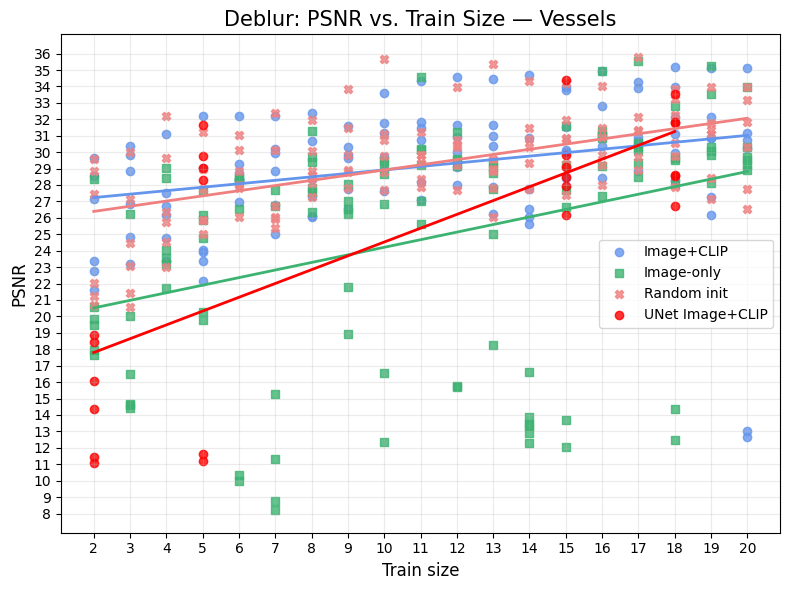

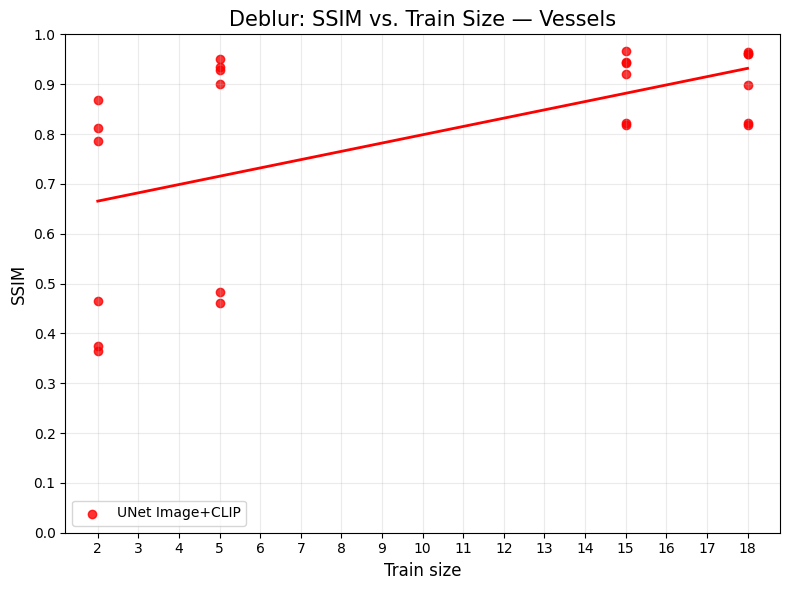

In [2]:
# ============================================================
# UPDATED DEBLURRING PSNR PLOTTING (x-axis = fttr + ftval)
# ============================================================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. CONFIGURATION
# --------------------------------------------------

RESULT_SETS = [
    # SwinUNETR deblur experiments
    ("Image+CLIP", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds"),
    ("Image-only", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31_v2/preds"),
    ("Random init", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random_v2/preds"),

    # UNet deblur experiments
    ("UNet Image+CLIP", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_super_sweep2_v2/preds"),
    ("UNet Random", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_super_sweep2_v2_random/preds"),
]

METRICS = ["psnr", "ssim"]

COLOR_MAP = {
    "Image+CLIP": "cornflowerblue",
    "Image-only": "mediumseagreen",
    "Random init": "lightcoral",
    "UNet Image+CLIP": "red",
    "UNet Random": "purple",
}

MARKER_MAP = {
    "Image+CLIP": "o",
    "Image-only": "s",
    "Random init": "X",
    "UNet Image+CLIP": "o",
    "UNet Random": "X",
}

# Pretty names
PRETTY_NAME = {
    "amyloid_plaque_patches": "Amyloid Plaque",
    "c_fos_positive_patches": "c-Fos Positive",
    "cell_nucleus_patches": "Cell Nucleus",
    "vessels_patches": "Vessels",
}


# --------------------------------------------------
# 2. LOAD DATA FROM ALL metrics_test.csv FILES
# --------------------------------------------------

rows = []

for label, root in RESULT_SETS:
    root = Path(root)

    if not root.exists():
        print(f"[WARN] Skipping missing path: {root}")
        continue

    csv_paths = sorted(root.rglob("metrics_test.csv"))
    print(f"[INFO] {label}: found {len(csv_paths)} metrics files")

    for csv_path in csv_paths:

        folder = str(csv_path)

        # -----------------------------
        # Extract fttr and ftval from folder name
        # -----------------------------
        m1 = re.search(r"fttr(\d+)", folder)
        m2 = re.search(r"ftval(\d+)", folder)

        if not (m1 and m2):
            print(f"[WARN] Missing fttr/ftval in path: {csv_path}")
            continue

        fttr = int(m1.group(1))
        ftval = int(m2.group(1))

        train_size = fttr + ftval   # NEW

        # -----------------------------
        # Extract subtype (datatype)
        # -----------------------------
        parts = csv_path.parts
        try:
            idx = parts.index("preds")
            subtype = parts[idx + 1]
        except ValueError:
            subtype = "unknown"

        # -----------------------------
        # Load metrics
        # -----------------------------
        df = pd.read_csv(csv_path)
        # drop MEAN rows if present (common in some pipelines)
        if "filename" in df.columns:
            df = df[df["filename"].astype(str).str.upper() != "MEAN"].copy()

        # Append metrics for each metric column we care about (if present)
        for metric_name in METRICS:
            if metric_name not in df.columns:
                print(f"[WARN] {metric_name.upper()} missing in {csv_path}")
                continue
            for val in df[metric_name].astype(float):
                rows.append({
                    "series": label,
                    "subtype": subtype,
                    "train_size": train_size,
                    "metric_name": metric_name,
                    "metric": float(val),
                    "csv_path": str(csv_path),
                })

data = pd.DataFrame(rows)
print(f"[INFO] Loaded {len(data)} metric points total")
print("[INFO] Datatypes:", sorted(data["subtype"].unique()))
display(data.head())


# --------------------------------------------------
# 3. PLOT PER DATATYPE
# --------------------------------------------------

for subtype in sorted(data["subtype"].unique()):

    sub_df = data[data["subtype"] == subtype].copy()
    if sub_df.empty:
        continue

    pretty = PRETTY_NAME.get(subtype, subtype.replace("_", " ").title())

    for metric_name in METRICS:
        mdf = sub_df[sub_df["metric_name"] == metric_name].copy()
        if mdf.empty:
            print(f"[WARN] No {metric_name} data for subtype={subtype}")
            continue

        plt.figure(figsize=(8, 6))

        # -----------------------------
        # PLOT ALL SERIES
        # -----------------------------
        for series in mdf["series"].unique():
            df_s = mdf[mdf["series"] == series]

            plt.scatter(
                df_s["train_size"],
                df_s["metric"],
                color=COLOR_MAP[series],
                marker=MARKER_MAP[series],
                alpha=0.8,
                label=series,
            )

            # best-fit line
            x = df_s["train_size"].values
            y = df_s["metric"].values
            if len(df_s) > 1 and len(np.unique(x)) > 1:
                a, b = np.polyfit(x, y, 1)
                xs = np.linspace(min(x), max(x), 200)
                ys = a * xs + b
                plt.plot(xs, ys, color=COLOR_MAP[series], linewidth=2)

        # -----------------------------
        # Axis formatting
        # -----------------------------
        xmin, xmax = mdf["train_size"].min(), mdf["train_size"].max()
        plt.xticks(np.arange(xmin, xmax + 1, 1))

        if metric_name == "psnr":
            ymin, ymax = mdf["metric"].min(), mdf["metric"].max()
            ymin_i = int(np.floor(ymin))
            ymax_i = int(np.ceil(ymax))
            plt.yticks(np.arange(ymin_i, ymax_i + 1, 1))
            ylab = "PSNR"
            title_metric = "PSNR"
        else:
            # SSIM typically lives in [0,1]
            plt.ylim(0.0, 1.0)
            plt.yticks(np.arange(0.0, 1.01, 0.1))
            ylab = "SSIM"
            title_metric = "SSIM"

        plt.xlabel("Train size", fontsize=12)
        plt.ylabel(ylab, fontsize=12)
        plt.title(f"Deblur: {title_metric} vs. Train Size — {pretty}", fontsize=15)

        plt.grid(True, alpha=0.25)
        plt.legend()
        plt.tight_layout()
        plt.show()
